# Torres de Hanoi

Las Torres de Hanoi es un juego infantil que consiste en un armazón con tres palos (torres) en los que se inserta un conjunto de discos de distinto tamaño con un agujero en su punto medio.

<img src="https://upload.wikimedia.org/wikipedia/commons/0/07/Tower_of_Hanoi.jpeg">

El juego consiste en mover los discos uno a uno desde un palo a otro manteniendo siempre una regla: *un disco nunca puede posarse sobre otro disco de menor tamaño*.  Esto exige utilizar el tercer palo como un punto intermedio.  Vamos a construir un programa para resolverlo.

La solución es trivial si empleamos una función recursiva.  Mover los ocho discos de la imagen al palo de la derecha solo se puede hacer si movemos los siete discos superiores al palo central, movemos entonces el disco mayor al palo de la derecha y entonces movemos los siete discos del palo central al palo de la derecha.  No hay otra posible solución, para que el disco mayor se mueva al palo de la derecha la única posibilidad es que no haya ningún disco en este palo y por tanto todos tienen que estar en el central.

Lo interesante de este análisis es que ya tenemos la solución final, porque mover los siete discos superiores al palo central es un problema complétamente análogo al anterior.  Hay que mover los seis discos superiores al derecho, mover el séptimo al palo central y entonces mover los seis discos superiores al palo central.

Podemos, por ejemplo, generar la lista completa de movimientos usando este método.  El algoritmo es sumamente sencillo.

1. Si no hay que mover ningún disco la lista de movimientos es la lista vacía.
1. Para mover N discos desde el palo X al palo Y:
    1. Determinar el otro palo Z.
    1. Mover N-1 discos de X a Z.
    1. Mover el disco N-simo de X a Y. Generar el movimiento `X -> Y`
    1. Mover N-1 discos de Z a Y.

Se trata de un algoritmo recursivo donde el primer caso es el caso base, que rompe la recursión.

In [1]:
def hanoi(ndiscos, desde=0, hasta=2):
    if ndiscos == 0:
        return []
    tmp = ({0,1,2} - {desde,hasta}).pop()
    return hanoi(ndiscos-1, desde, tmp) + [(desde, hasta)] + hanoi(ndiscos-1, tmp, hasta)

La forma en que determinamos el otro palo puede parecerte extraña en este momento.  Vamos a explicarla un poco.  Nuestra implementación utiliza conjuntos de Python.  Un conjunto es similar a una lista pero los elementos no pueden repetirse y se colocan en orden.  Se definen con llaves en lugar de corchetes: 

In [2]:
A = {1,2,5,3,2,1,4}
A

{1, 2, 3, 4, 5}

Los conjuntos permiten las operaciones normales del álgebra de Boole.  En particular la resta de conjuntos elimina del conjunto minuendo todos los elementos del sustraendo:

In [3]:
A - {2,5,9}

{1, 3, 4}

Si los palos los numeramos del 0 al 2, el conjunto de todos los palos es `{0,1,2}` y el conjunto de todos los palos menos el origen y el destino es el conjunto `{0,1,2} - {desde,hasta}`.  Por ejemplo si el origen es el `0` y el destino el `2` tendríamos:

In [4]:
{0,1,2} - {0,2}

{1}

Esto es un conjunto de un único elemento, que podemos extraer usando la función `pop` que tienen todos los contenedores (las listas también).

Lo demás no es más que la expresión directa del algoritmo teniendo en cuenta que debe devolver una lista con los movimientos y que cada movimiento no es más que la pareja de valores del palo origen y el palo destino.  Cuando movemos N-1 discos tenemos que recoger la lista de movimientos correspondientes y añadirla en el punto adecuado a nuestro valor de retorno.

Vamos a hacer una prueba.

In [5]:
hanoi(3)

[(0, 2), (0, 1), (2, 1), (0, 2), (1, 0), (1, 2), (0, 2)]

## Usando generadores

Ya hemos resuelto el problema y funciona correctamente, pero ¿qué pasaría si el número de discos es 10? ¿y 12? ¿y 20?

In [6]:
len(hanoi(10)), len(hanoi(12)), len(hanoi(20))

(1023, 4095, 1048575)

En general para $n$ discos obtenemos una lista de $2^n - 1$ movimientos.  Eso es mucho.  ¿Es necesario guardar todos los números en memoria?

En muchas situaciones podemos ahorrar un montón de memoria si hacemos lo mismo que la función `range`.  Podemos ir generando los números conforme los vaya pidiendo el usuario.  Para eso están los generadores en Python.  Basta producir los movimientos con `yield`.  Esta palabra reservada suspende la ejecución de la función hasta que el usuario llame a la función `next`.  Escribir la función de esta forma es un poco más lioso pero tampoco mucho.

In [8]:
def hanoi(ndiscos, desde=0, hasta=2):
    if ndiscos == 0:
        return []
    tmp = ({*range(3)} - {desde,hasta}).pop()
    yield from hanoi(ndiscos-1, desde, tmp)
    yield (desde, hasta)
    yield from hanoi(ndiscos-1, tmp, hasta)

Ya no construimos una lista sino que producimos movimientos con `yield`.  Cuando necesitamos mover N-1 discos tendremos que llamar de forma recursiva a `hanoi`, pero ahora se usa igual que `range`, tendremos que iterar sobre sus elementos con un `for`.

La forma en que se usa ahora es similar a `range`.

In [9]:
print(*hanoi(3))

(0, 2) (0, 1) (2, 1) (0, 2) (1, 0) (1, 2) (0, 2)


In [10]:
for mov in hanoi(3):
    print(mov, end=' ')

(0, 2) (0, 1) (2, 1) (0, 2) (1, 0) (1, 2) (0, 2) 

Habrás notado que no hemos representado las torres de ninguna forma en ningún momento.  No es necesario para resolver el problema pero puede ser útil para visualizar el estado de las torres en cada paso.  Eso se puede hacer a posteriori fácilmente si usamos generadores.

In [11]:
def torres_hanoi(ndiscos, desde=0, hasta=2):
    torres = [[],[],[]]
    torres[desde] = list(reversed(range(ndiscos)))
    yield torres
    for desde, hasta in hanoi(ndiscos, desde, hasta):
        torres[hasta].append(torres[desde].pop())
        yield torres

In [12]:
for torres in torres_hanoi(3):
    print(*torres, sep='\t\t')

[2, 1, 0]		[]		[]
[2, 1]		[]		[0]
[2]		[1]		[0]
[2]		[1, 0]		[]
[]		[1, 0]		[2]
[0]		[1]		[2]
[0]		[]		[2, 1]
[]		[]		[2, 1, 0]


También es sencillo obtener el estado después de *n* iteraciones del algoritmo.

In [13]:
def torres_hanoi_nth(n, ndiscos=8):
    mov = torres_hanoi(ndiscos, desde=0, hasta=2)
    for i in range(n):
        next(mov)
    return next(mov)

Por ejemplo, veamos el estado después de 20 iteraciones en el caso de 8 discos.

In [14]:
print(*torres_hanoi_nth(20, ndiscos=8))

[7, 6, 5, 2] [4, 1, 0] [3]


En realidad esto mismo se puede hacer con funciones de la biblioteca estándar.  Por ejemplo, `islice` es un generador que solo produce un rango de elementos de otro generador.  En este caso simplemente nos saltamos hasta el elemento *n-simo*  y producimos un elemento entonces.

In [15]:
from itertools import islice

def torres_hanoi_nth(n, ndiscos=8):
    return next(islice(torres_hanoi(ndiscos, desde=0, hasta=2), n, None))

In [16]:
print(*torres_hanoi_nth(20, ndiscos=8))

[7, 6, 5, 2] [4, 1, 0] [3]


## Interfaces de usuario con Jupyter Notebook

Este tipo de ejercicios se presta a una visualización más gráfica.  Vamos a ver lo mínimo para construir interfaces de usuario con Jupyter.  

Necesitaremos una forma de dibujar las torres y una forma de proporcionar una interfaz de usuario para controlar lo que ya hemos hecho.

En Jupyter Notebook (y por tanto [tmpnb.org](http://tmpnb.org) tenemos acceso a todas las capacidades del navegador.  En particular podemos dibujar gráficos escalables utilizando el [estándar SVG](https://www.w3.org/Graphics/SVG/).  Los gráficos SVG se pueden generar con cualquier programa de dibujo vectorial (e.g. [Inkscape](http://www.inkscape.org)) pero en este ejemplo lo vamos a hacer a mano.

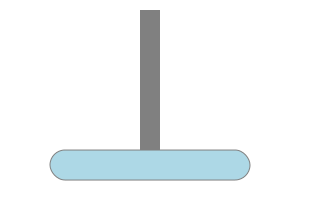

In [17]:
from IPython.display import SVG
SVG(data='''
<svg width="320" height="200">
  <line x1="150" x2="150" y1="10" y2="150" stroke="gray" stroke-width="20"/>
  <rect x="50" y="150" rx="15" ry="15" width="200" height="30" 
        stroke="gray" fill="lightblue" stroke-width="1"/>
</svg>
''')

No es muy complicado, ¿verdad?  Vamos a construir una función que dado un conjunto de torres con sus discos correspondientes dibuje el SVG equivalente.

In [18]:
grosor = 30
diametro_max = 9*grosor

def torres_svg(torres):
    ndiscos = sum([len(t) for t in torres])
    return SVG(data='<svg width="{}" height="{}">{}</svg>'.format(
            3*diametro_max,
            ndiscos*grosor,
            ''.join([torre_svg(t,i,ndiscos) for i, t in enumerate(torres)])))

def torre_svg(torre, pos, ndiscos):
    return '''<line x1="{0}" x2="{0}" 
                    y1="0" y2="{1}" 
                    stroke="gray" 
                    stroke-width="20"/>{2}'''.format(
        (0.5 + pos)*diametro_max,
        ndiscos*grosor,
        ''.join([disco_svg(tamano, pos, posy, ndiscos) for posy, tamano in enumerate(torre)]))

def disco_svg(tamano, posx, posy, ndiscos):
    diametro = diametro_max - (ndiscos - tamano - 1)*grosor
    return '''<rect x="{0}" y="{1}" 
                    width="{2}" height="{3}" 
                    rx="{4}" ry="{4}" 
                    stroke="gray" fill="lightblue" stroke-width="1"/>'''.format(
        (0.5 + posx)*diametro_max - diametro/2,
        ndiscos*grosor - (posy + 1)*grosor,
        diametro, grosor, grosor/2)

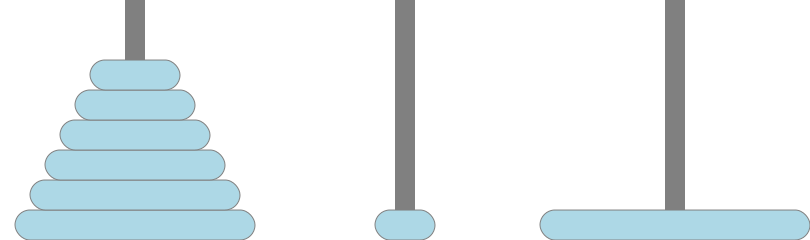

In [19]:
torres_svg([[6, 5, 4, 3, 2, 1], [0], [7]])

In [20]:
torres_hanoi_nth(20, ndiscos=8)

[[7, 6, 5, 2], [4, 1, 0], [3]]

In [21]:
from ipywidgets import interact

@interact(n=(0,255), ndiscos=(2,8))
def torres_svg_nth(n, ndiscos=8):
    return torres_svg(torres_hanoi_nth(n, ndiscos))

# O con código
#interact(torres_svg_nth, n=(0,255), ndiscos=(2,8))

interactive(children=(IntSlider(value=127, description='n', max=255), IntSlider(value=8, description='ndiscos'…